Structure of the paper will be as follows...

R2 - IS and OOS, boostrap errors.

New Loss function v random - IS and OOS, boostrap errors.

### 0.0 Inputs...

In [1]:
from __future__ import division, print_function

import joblib
import numpy as np
from IPython.display import SVG
from scipy.spatial.distance import pdist, squareform, jaccard, cityblock
from scipy import stats

from multiprocessing import Pool
from copy import deepcopy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model as LM

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso

from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR

# Deep learning model with intermediate layer...
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=100, batch_size=5, verbose=0)))

# Model dictionaries 
model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}, },
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 
                                                              'n_jobs':4, 'max_depth':10}, },
              'svr'   : {'m' : SVR, 'kw' : {}, },
              
              'dl_l'   : {'m' : Pipeline, 
                          'kw' : {'steps': [('standardize', StandardScaler()),
                                            ('mlp', KerasRegressor(build_fn=larger_model, 
                                                                   epochs=100, batch_size=5, 
                                                                   verbose=0))
                                                           ]},
                         },
             }

# Datasets
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

import matplotlib.pyplot as plt
%pylab inline
figsize(20, 10)
import seaborn as sns

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Take out when we want to run deep learning model
del model_dict['dl_l']

In [3]:
# Syntax testing...
#del model_dict['rf']
#del model_dict['svr']

In [4]:
# Pull in data for a single target name
def get_data(tgt_name='COX-2'):
    data_dir = 'datasets/' + tgt_name + '/'
    preds = joblib.load(data_dir + tgt_name + '_predsu.npy')
    resps = joblib.load(data_dir + tgt_name + '_respu.npy')
    smiles = joblib.load(data_dir + tgt_name + '.smiu')
    return preds, resps, smiles

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def avg_mse(predictions, responses, **kwargs):
    return mean_squared_error(responses, predictions) / mean_squared_error(responses, np.zeros_like(responses))


def james_loss(predictions, responses, **kwargs):
    
    tgt_val = kwargs.get('tgt_val')
    ranked = np.argsort(-predictions)
    found = responses[ranked] >= tgt_val
    # Number of actives
    N_gamma = np.sum(found)
    
    # Size of test sets
    N_test = predictions.shape[0]
    lt = kwargs.get('loss_type')
    #pdb.set_trace()
    if lt == 'min':
        # Equation (1) of the paper
        loss = 1/(N_test - N_gamma) * np.min(np.arange(N_test)[found])
    elif lt == 'avg':
        # Equation (2) of the paper
        loss = 1/N_gamma * 1/(N_test - N_gamma) * (np.sum(np.arange(N_test)[found]) - N_gamma * (N_gamma - 1)/2)
        pass
    
    assert loss >= 0
    assert loss <= 1
    return loss


def james_loss_avg(predictions, responses, **kwargs):
    kwargs.update({'loss_type' :'avg'})
    return james_loss(predictions, responses, **kwargs)

def james_loss_min(predictions, responses, **kwargs):
    kwargs.update({'loss_type' :'min'})
    return james_loss(predictions, responses, **kwargs)


def nbs_run(kwargs):
    my_is = kwargs.get('is')
    my_oos = kwargs.get('oos')
    method = kwargs.get('method')
    preds = kwargs.get('preds') + 0.
    resps = kwargs.get('resps')
    
    mdl = model_dict[method]['m'](**model_dict[method]['kw'])
    mdl.fit(preds[my_is], resps[my_is])
        
    predictions = mdl.predict(preds[my_oos])
    
    losses = {}
    for (l, v) in loss_dict.iteritems():
        
        # Worth noting, we're looking for the to frac_find _in_the_oos_data_
        # (not in the whole data - as otherwise we might be looking for something
        # that isn't there)
        if 'frac_find' in v['kw']:
            N = len(resps[my_oos])
            sorted_indices = np.argsort(resps[my_oos])
            n = int(N * v['kw']['frac_find'])
            tgt_val = resps[my_oos][sorted_indices[n]]
            v['kw'].update({'tgt_val' : tgt_val})
            
        losses[l] = v['func'](predictions, resps[my_oos], **v['kw'])
        pass
    
    return losses
    
    
def full_bootstrap(preds, resps, method, num_runs=100, insample=False,
                  frac_fit=1.0, num_kf=0, use_pool=True):

    # losses is going to be a list of dicts, loss_type => value
    losses = []
    sorted_indices = np.argsort(resps)

    N = len(resps)
    M = int(N * frac_fit)
    
    # Choose insample values...
    idx_list = []
    for i in range(num_runs):
        if num_kf > 0:
            kf = KFold(n_splits=num_kf, shuffle=True)
            for (tr_i, tst_i) in kf.split(np.arange(M)):
                idcs = sorted_indices[tr_i]
                pass
            pass
        else:
            idcs_rand = np.random.choice(M, M)
            idcs = sorted_indices[idcs_rand]
            pass
        idx_list.append({'is' : idcs})
        pass
    
    # Add in all the other data...
    for d in idx_list:
        if insample:
            oos = d['is']
        else:
            oos = np.delete(np.arange(N), d['is'])
            pass
        d.update({'oos' : oos, 'preds' : preds, 
                  'resps' : resps, 'method' : method})
        pass
            
    if use_pool:
        p = Pool(5)
        losses = p.map(nbs_run, idx_list)
        p.close()
        p.join()
    else:
        losses = [nbs_run(x) for x in idx_list]
        pass
    return losses

In [6]:
# Unit tests for the loss functions...
responses = np.arange(10)
tgt_val = 8

# get it totally right
predictions = np.arange(10)

print('All correct')
print('r2', avg_mse(predictions, responses, tgt_val=tgt_val))
print('james min', james_loss_min(predictions, responses, tgt_val=tgt_val))
print('james avg', james_loss_avg(predictions, responses, tgt_val=tgt_val))

# get it totally right where it counts, but maximally wrong elsewhere
#predictions = np.asarray([0])

# one totally right, one totally wrong
predictions = np.roll(np.arange(10),-1)
print('\nOne right, one very wrong')
print('r2', avg_mse(predictions, responses, tgt_val=tgt_val))
print('james min', james_loss_min(predictions, responses, tgt_val=tgt_val))
print('james avg', james_loss_avg(predictions, responses, tgt_val=tgt_val))


# get everything wrong
predictions = np.arange(10)[::-1]
print('\nAll wrong')
print('r2', avg_mse(predictions, responses, tgt_val=tgt_val))
print('james min', james_loss_min(predictions, responses, tgt_val=tgt_val))
print('james avg', james_loss_avg(predictions, responses, tgt_val=tgt_val))
# 

All correct
r2 0.0
james min 0.0
james avg 0.0

One right, one very wrong
r2 0.315789473684
james min 0.0
james avg 0.5

All wrong
r2 1.15789473684
james min 1.0
james avg 1.0


In [7]:
def summarize(results):
    summary = {}
    for l in loss_dict.keys():
        vals = np.asarray([x[l] for x in results])
        if len(vals) == 1:
            summary[l] = {'loss' : vals[0]}
        else:
            summary[l] = {'loss_l' : np.percentile(vals, 5),
                          'loss' : np.mean(vals),                          
                          'loss_u' : np.percentile(vals, 95),
                         }
            pass
        pass
    return summary

In [8]:
# This function takes the vector of observed values and their mean (implies fewer computations of the mean)
def jackknife(vals, vals_bar):
    n = len(vals)
    var_JK = 0.0
    for v in vals:
        vals_bar_i = (n/(n-1)) * (vals_bar - v/n)
        #print(pow(vals_bar_i - vals_bar, 2))
        var_JK += pow(vals_bar_i - vals_bar, 2)
        pass

    sd_JK = pow( ((n-1)/n) * var_JK, .5)
   
    return sd_JK
    
def jackknife_summary(results):
    summary = {}
    for l in loss_dict.keys():
        vals = np.asarray([x[l] for x in results])
        if len(vals) == 1:
            summary[l] = {'loss' : vals[0]}
        else:
            vals_bar = np.mean(vals)
            sd = jackknife(vals, vals_bar)
            summary[l] = {'loss_l' : vals_bar - 2*sd,
                          'loss' : vals_bar,                          
                          'loss_u' : vals_bar + 2*sd,
                         }
            pass
        pass
    return summary


xs = np.random.normal(loc=0, scale=1, size=100)
len(xs)
jackknife(xs, np.mean(xs))

0.086785825225219368

In [9]:
sorted_targets = sorted(targets, key=lambda x: len(get_data(x)[0]))

In [10]:
import os.path

loss_dict = {'mse' :       {'func' : avg_mse,         'kw' : {}},
             'jmin_90' :   {'func' : james_loss_min,  'kw' : {'frac_find' : 0.9}},
             'javg_90' :   {'func' : james_loss_avg,  'kw' : {'frac_find' : 0.9}},
             'jmin_95' :   {'func' : james_loss_min,  'kw' : {'frac_find' : 0.95}},
             'javg_95' :   {'func' : james_loss_avg,  'kw' : {'frac_find' : 0.95}},
             'jmin_99' :   {'func' : james_loss_min,  'kw' : {'frac_find' : 0.99}},
             'javg_99' :   {'func' : james_loss_avg,  'kw' : {'frac_find' : 0.99}},
                           }
def get_fn(frac_fit, kf=0, insample=False):
    fn = 'loss_' + str(frac_fit)
    if kf > 0:
        fn += '_kf_' + str(kf)
        pass
    if insample:
        fn += '_insample'
        pass
    return os.path.join('models_final', fn)

def runner(frac_fit=1.0, kf=0, insample=False, use_pool=True):

    fnf = get_fn(frac_fit, kf=kf, insample=insample)
    if os.path.isfile(fnf) and not force_rerun:
        print('Already computed')
        return

    loss_hdr = {}
    if insample:
        num_runs = 1
    elif kf > 0:
        num_runs = int(400/kf)
    else:
        num_runs = 400
    
    for tgt in sorted_targets:
        loss_hdr[tgt] = {}
        print ('Doing', tgt)
        preds, resps, _ = get_data(tgt)
        preds = preds + 0.
        for m in model_dict.keys():
            res = full_bootstrap(preds, resps, m, frac_fit=frac_fit, num_kf=kf,
                                 insample=insample, num_runs=num_runs, use_pool=use_pool,
                                )
            joblib.dump(res, 'models_final/detail/' + tgt + '_' + m + '_' + str(frac_fit) + '_' + str(kf) + '.res')
            loss_hdr[tgt][m] = jackknife_summary(res)
        pass
    joblib.dump(loss_hdr, fnf)
    print('Completed')
    return

In [53]:
import matplotlib.pyplot as plt
%pylab inline
figsize(20, 10)
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [54]:
force_rerun = False

In [55]:
# insample run...
runner(insample=True)

Already computed


In [56]:
# Full OOS run...
runner()

Already computed


In [57]:
# OOS run with 5-fold CV for comparison
runner(kf=5)

Already computed


In [58]:
# OOS - max activity at 0.9
runner(frac_fit=0.9)

Already computed


In [59]:
# OOS - max activity at 0.8
runner(frac_fit=0.8)

Already computed


In [60]:
# OOS - max activity at 0.6
runner(frac_fit=0.6)

Already computed


In [61]:
# OOS - max activity at 0.4
runner(frac_fit=0.4)

Already computed


In [62]:
def plotter(frac_fit=1.0, kf=0, insample=False, loss='mse', scale='lin'):
    
    fnf = get_fn(frac_fit, kf=0, insample=insample)
    
    loss_hdr = joblib.load(fnf)
    
    offset = 0
    if scale == 'log':
        offset = 1
        pass
    
    for (i, method) in enumerate(model_dict.keys()):
        losses = np.asarray([loss_hdr[x][method][loss]['loss'] for x in sorted_targets]) + offset
        if insample:
            plot(np.arange(25) + 0.05*i, losses,  label=method.upper())
        else:
            loss_l = np.asarray([loss_hdr[x][method][loss]['loss_l'] for x in sorted_targets]) + offset
            loss_u = np.asarray([loss_hdr[x][method][loss]['loss_u'] for x in sorted_targets]) + offset
            
            yerr = np.vstack((losses - loss_l, loss_u - losses))
            
            errorbar(np.arange(25)+i*0.1, losses, capsize=10, yerr=yerr, label=method.upper())
            pass
        pass
    
    if scale == 'log':
        yscale('log')
        ylabel('log(1 + loss)')
        
    if insample:
        title('Insample %s Loss' % loss.upper())
    else:
        ttl = 'OOS %s Loss' % loss.upper()
        if kf > 0:
            ttl += ' with %d fold CV' % kf
        if frac_fit < 1.0:
            ttl += ' Max activity in fit at %.1f' % frac_fit
        title(ttl)
    pass

    grid(True)
    plt.xticks(np.arange(25), sorted_targets, rotation=-45)
    legend(loc='best')

### Insample loss plots

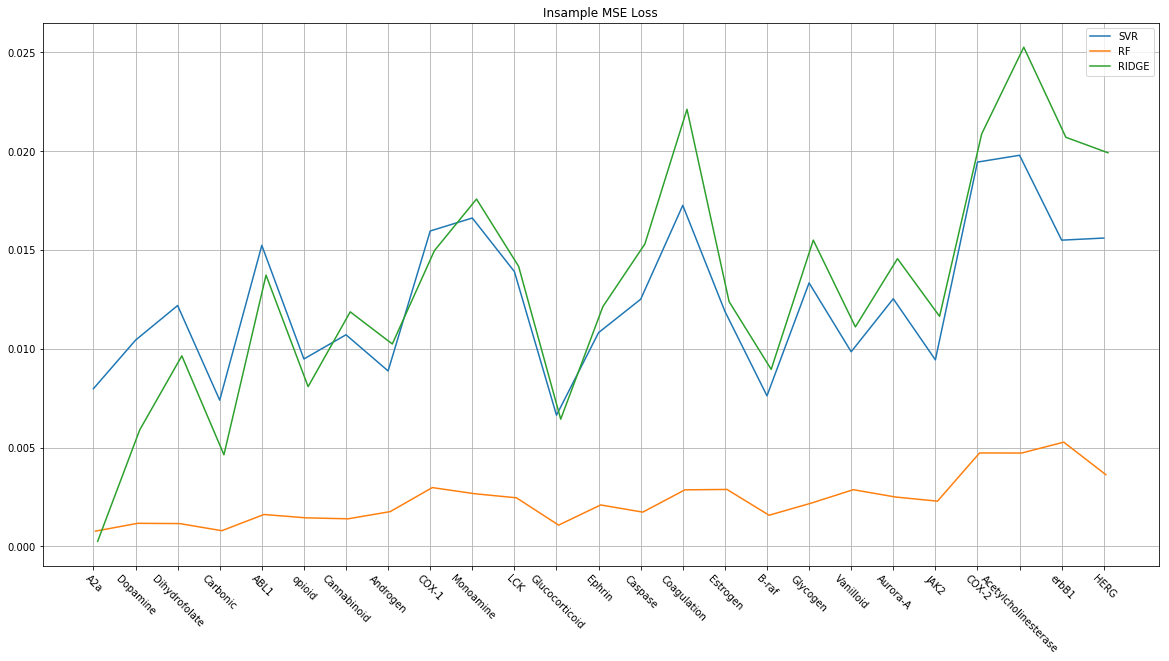

In [63]:
plotter(insample=True)

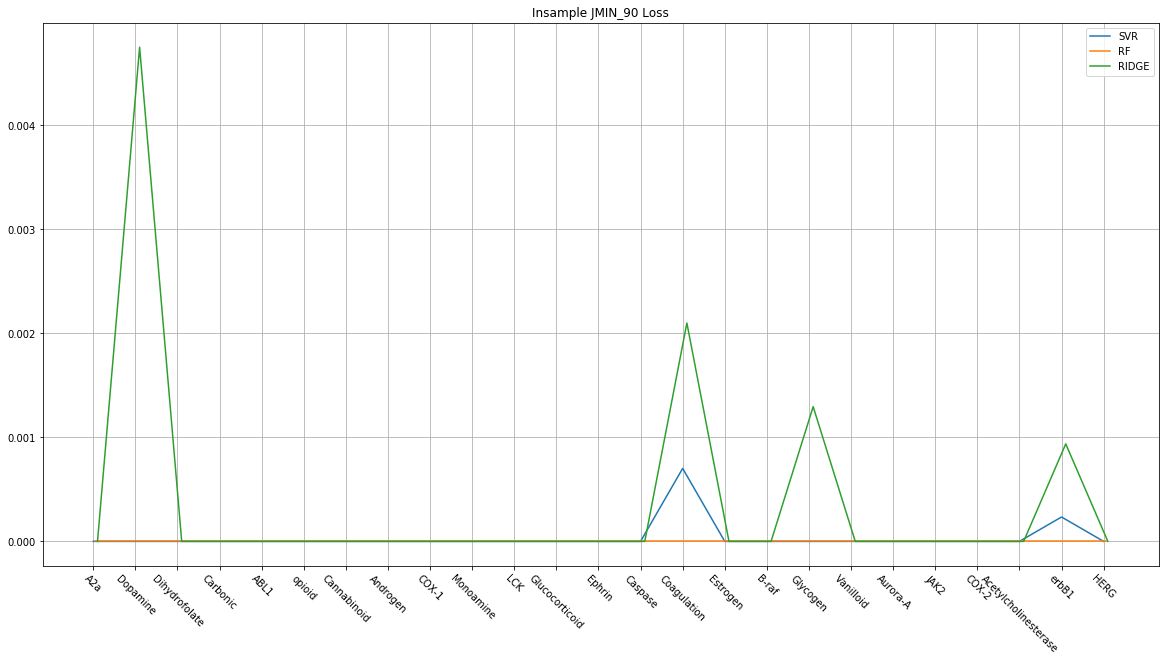

In [64]:
plotter(insample=True, loss='jmin_90')

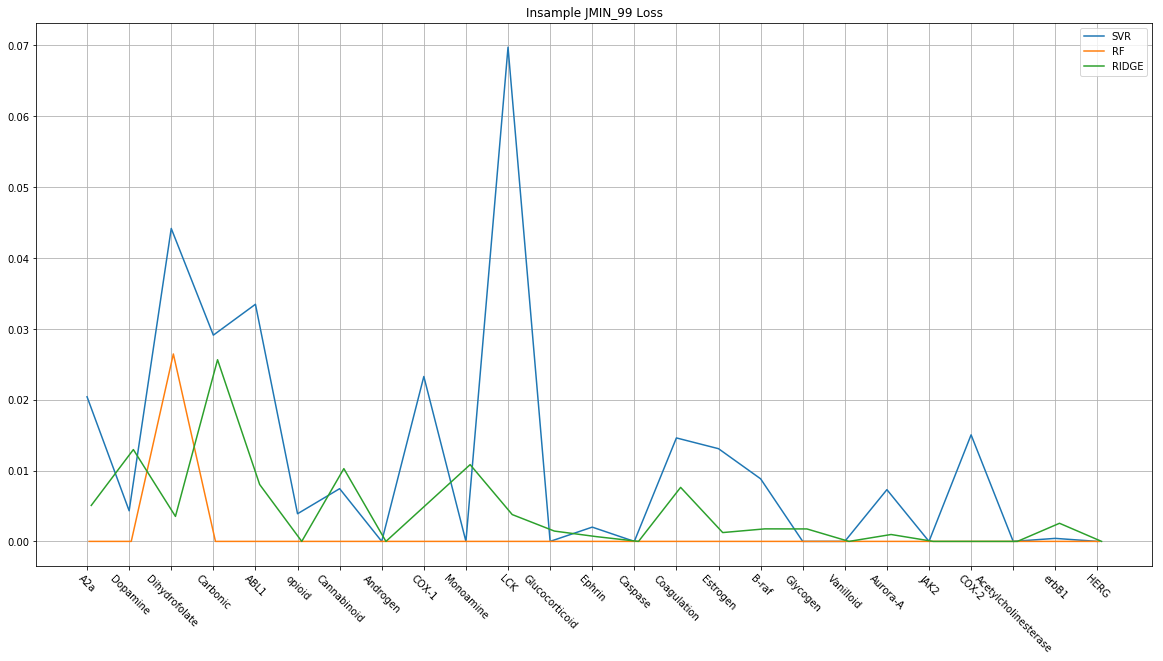

In [65]:
plotter(insample=True, loss='jmin_99')

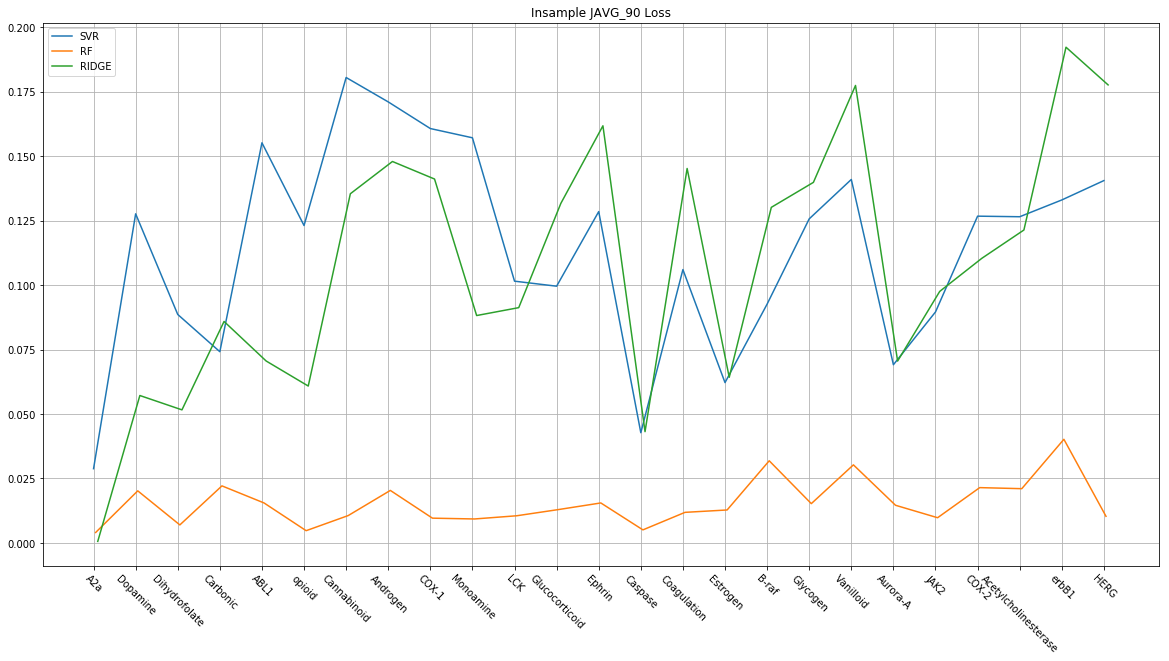

In [66]:
plotter(insample=True, loss='javg_90')

### OOS (no fit restriction) loss plots (using CV)

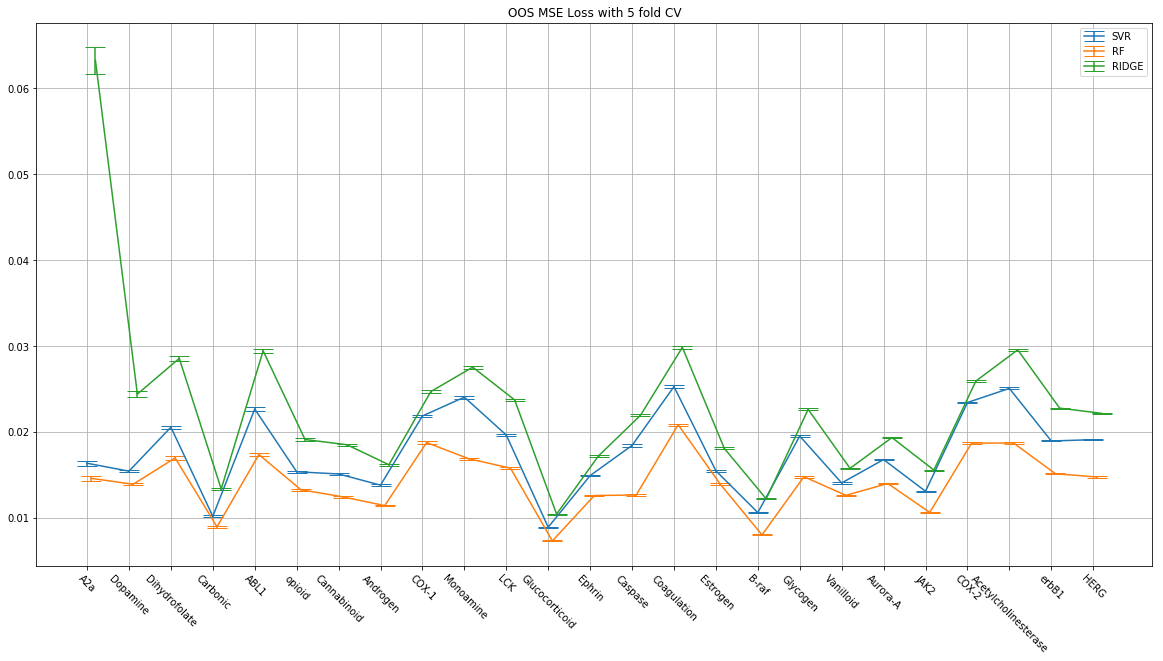

In [67]:
plotter(kf=5)

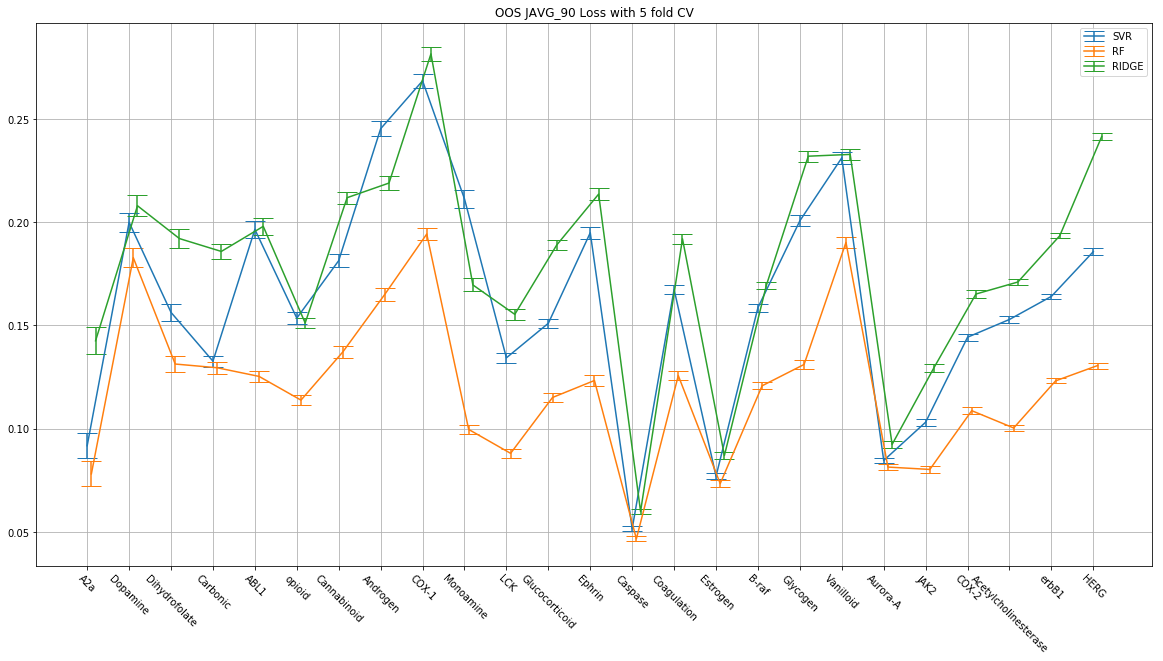

In [68]:
plotter(kf=5, loss='javg_90')

### OOS (no fit restriction) loss plots...

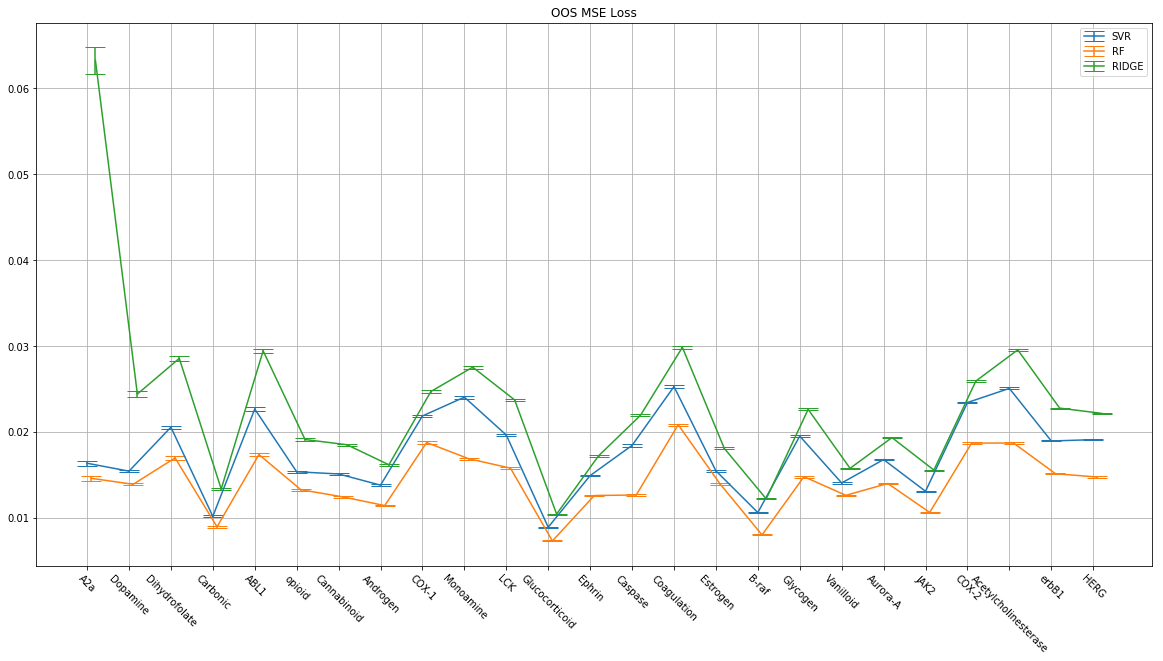

In [69]:
plotter()

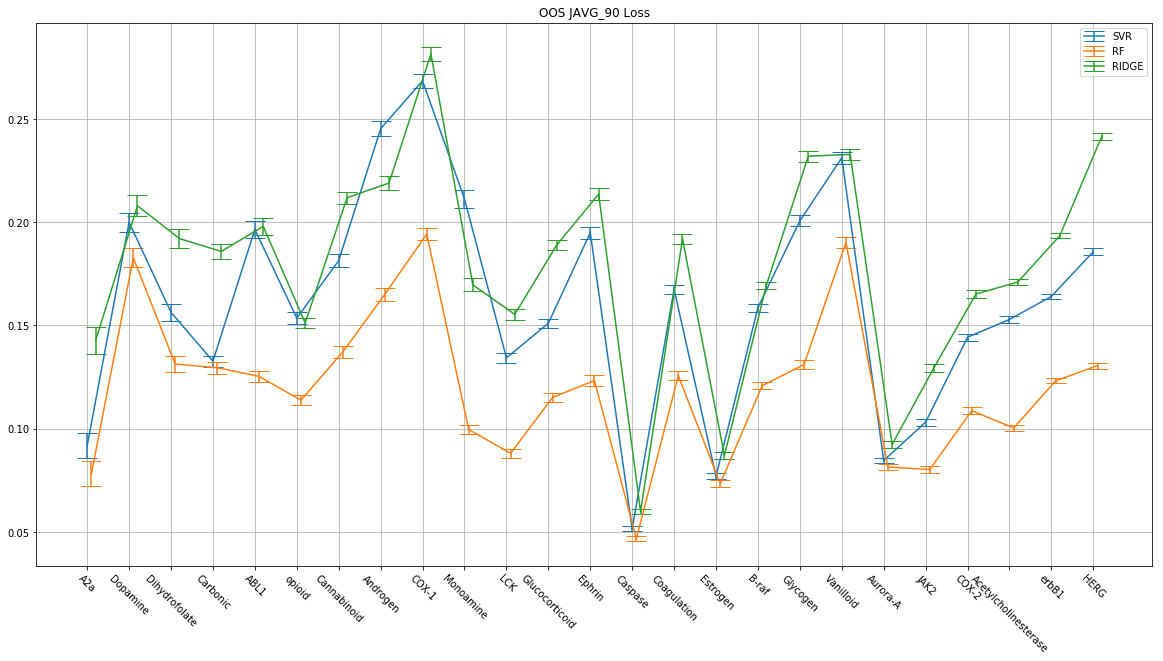

In [70]:
plotter(loss='javg_90')

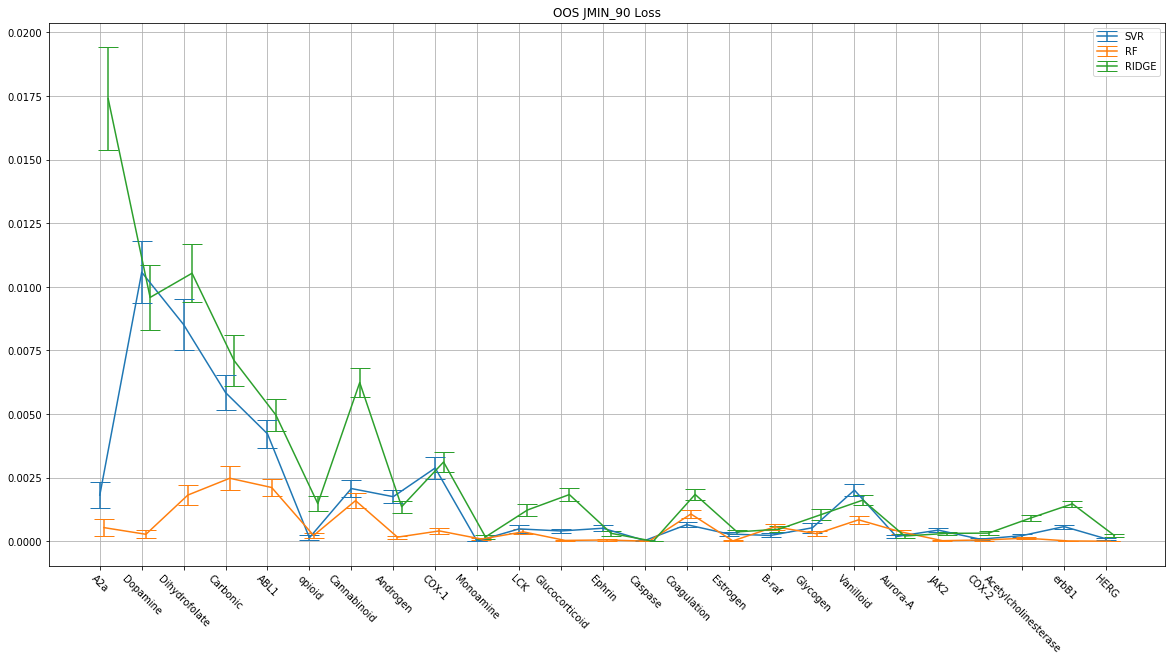

In [71]:
plotter(loss='jmin_90')

### OOS plots (0.9 frac fit)

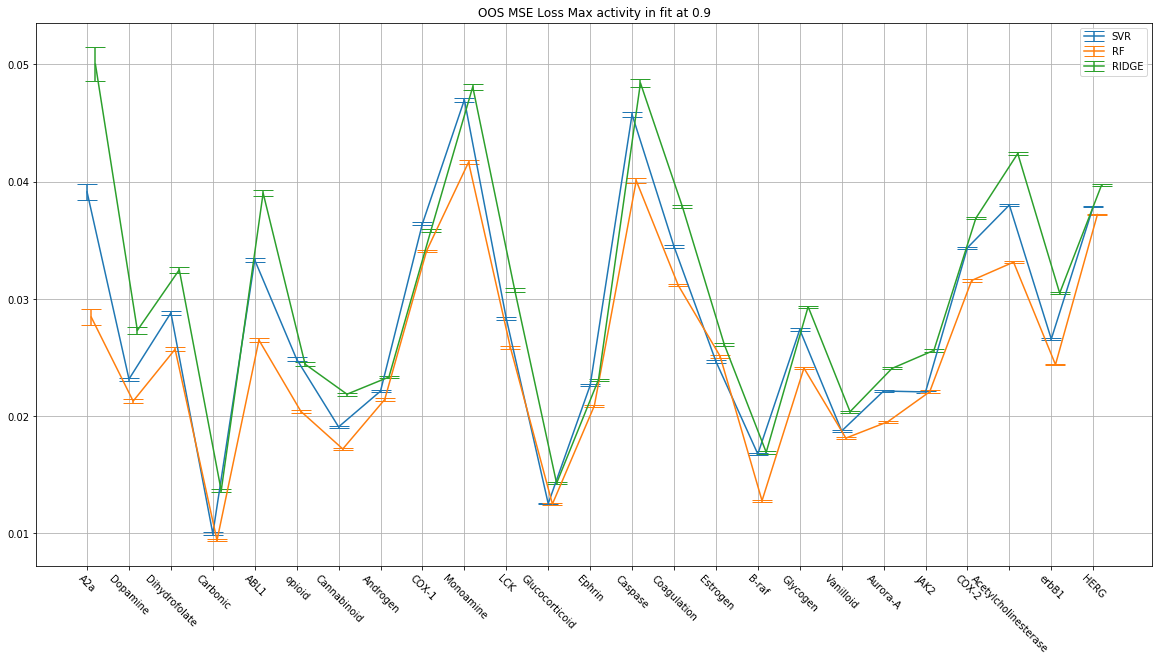

In [72]:
plotter(frac_fit=0.9)

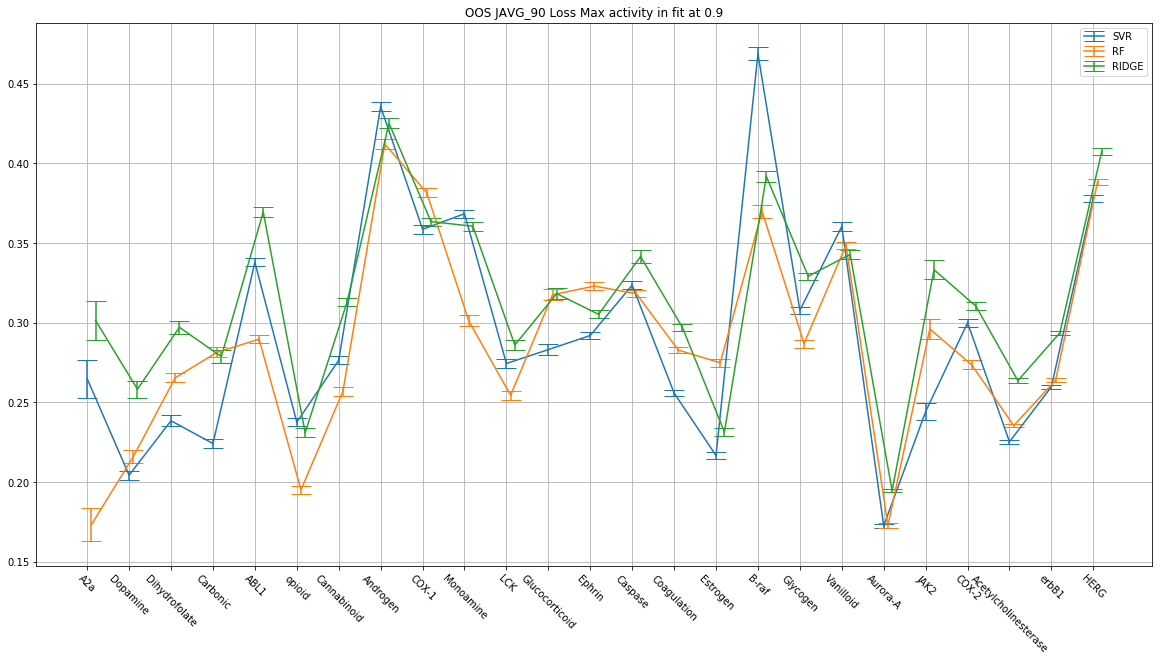

In [73]:
plotter(frac_fit=0.9, loss='javg_90')

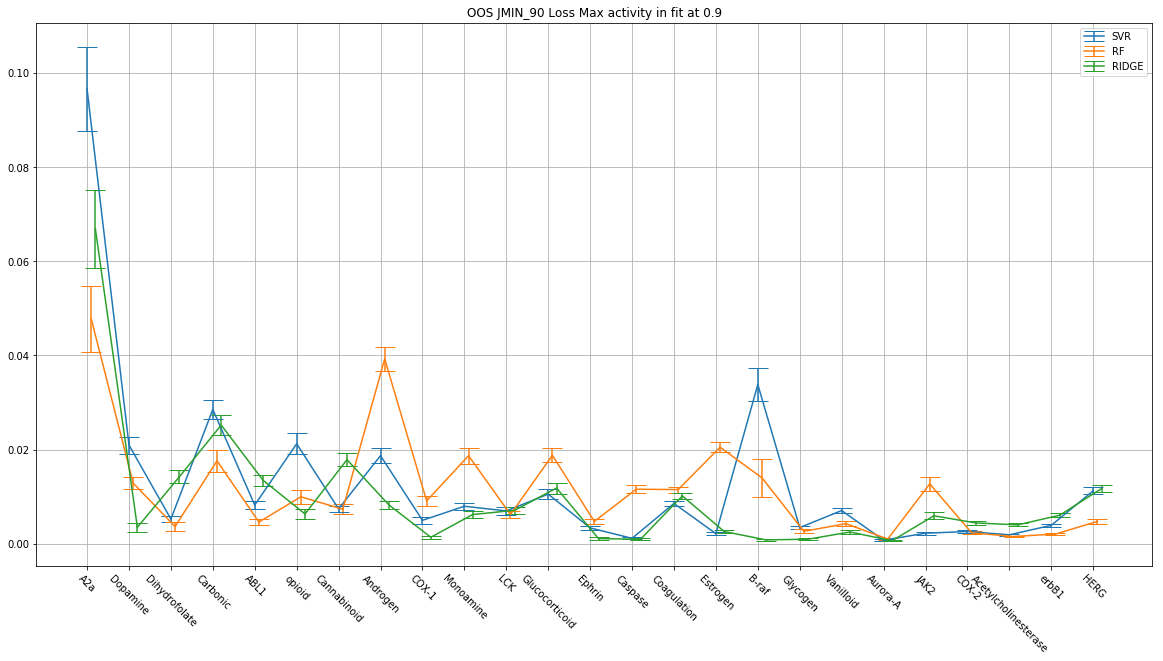

In [74]:
plotter(frac_fit=0.9, loss='jmin_90')

### OOS loss (max activity at 0.8)

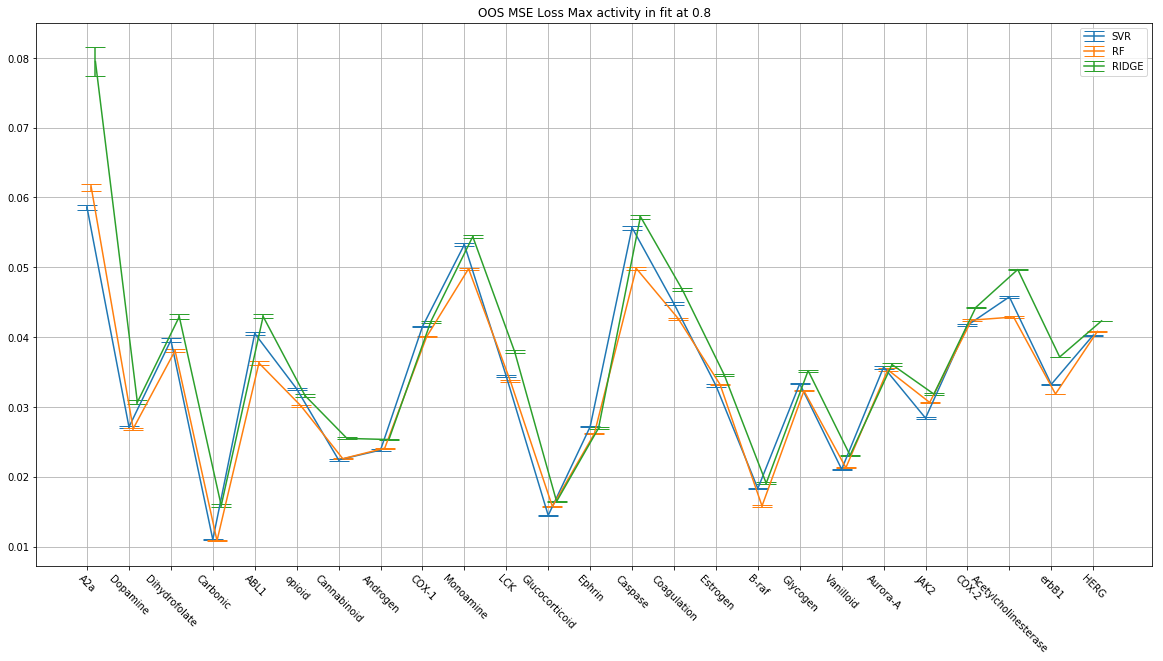

In [75]:
plotter(frac_fit=0.8)

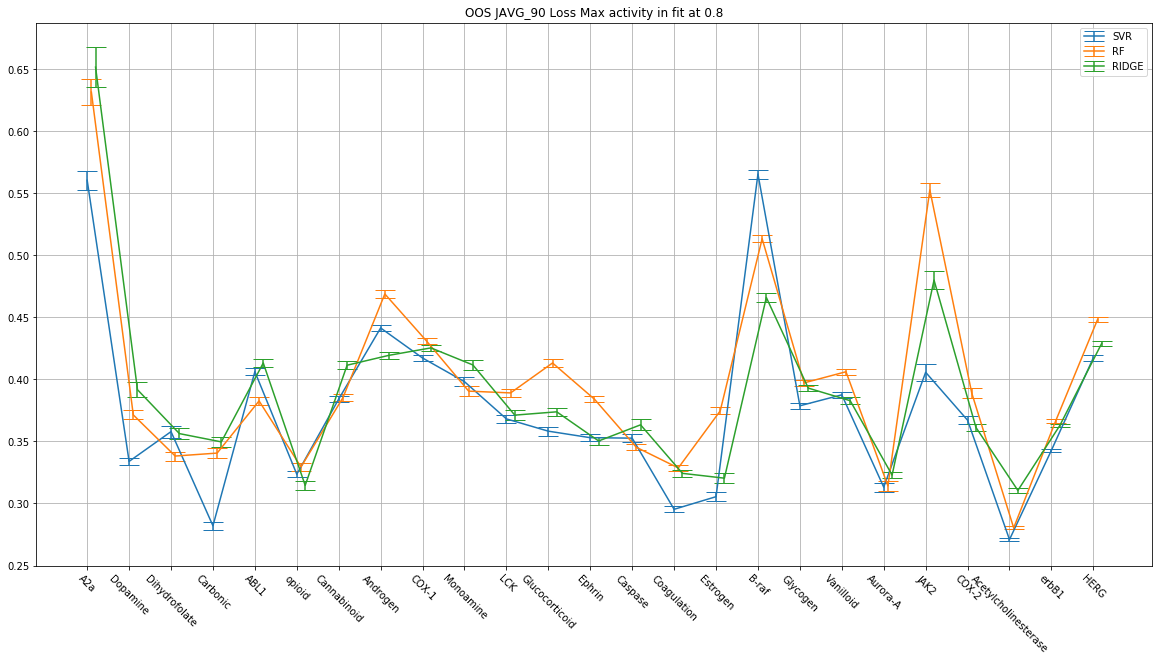

In [76]:
plotter(frac_fit=0.8, loss='javg_90')

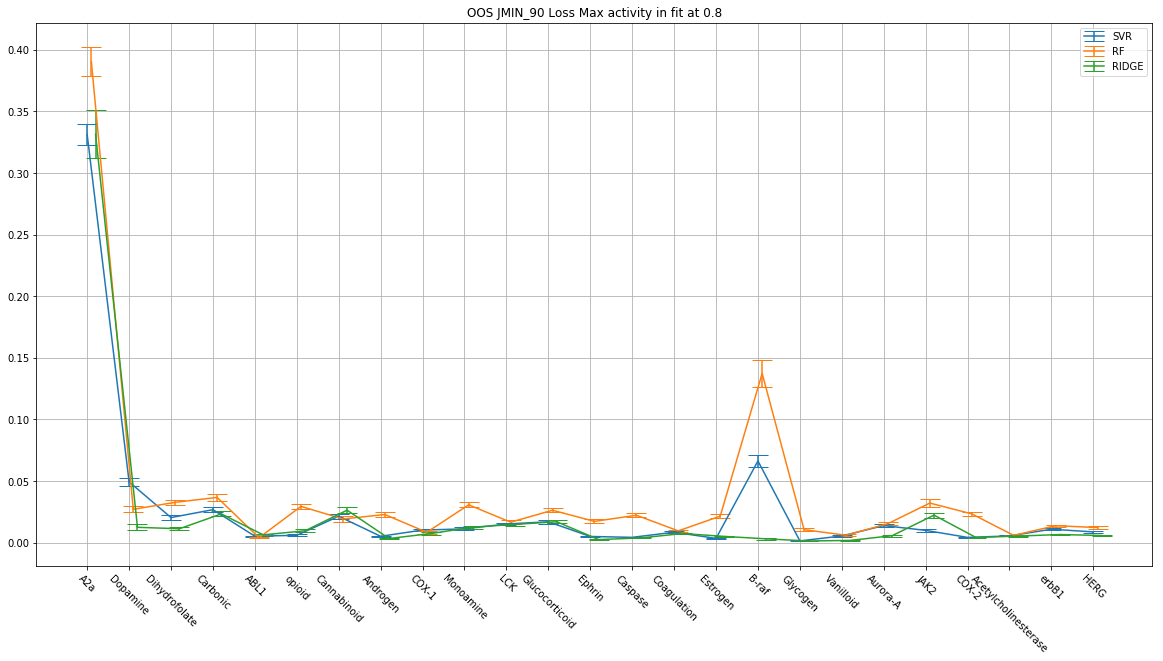

In [77]:
plotter(frac_fit=0.8, loss='jmin_90')

### OOS loss - max activity 0.6

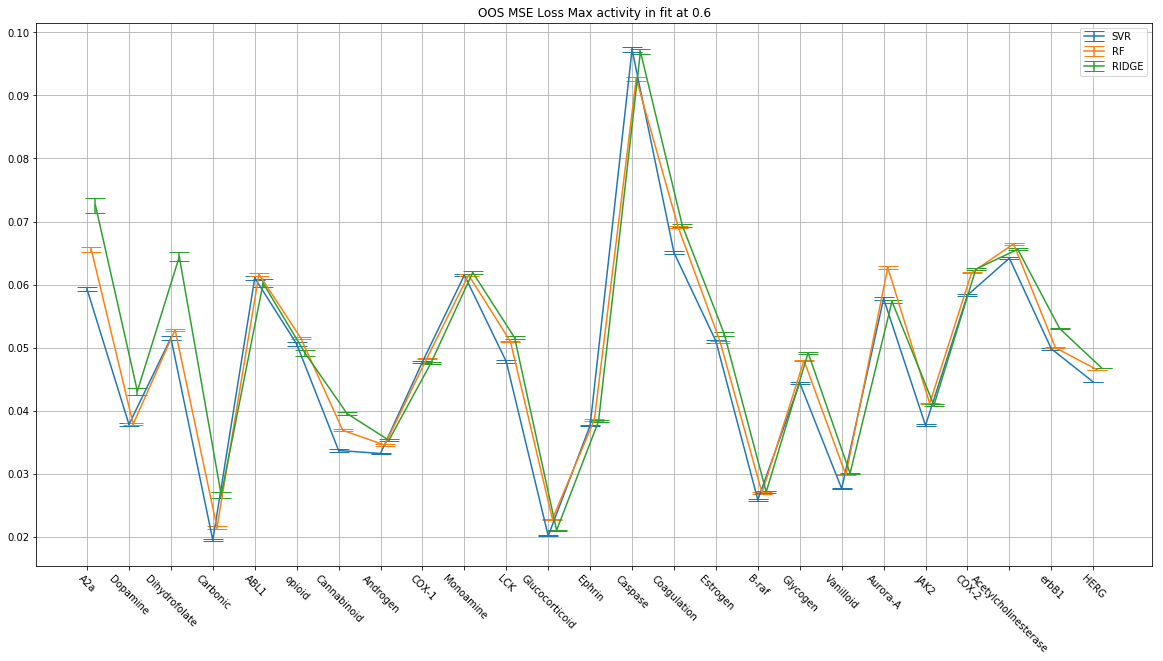

In [78]:
plotter(frac_fit=0.6)

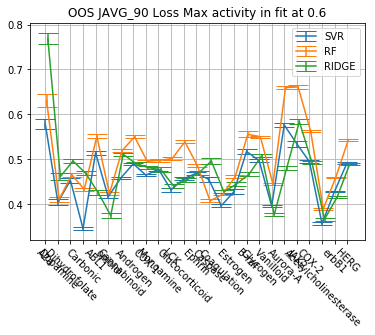

In [36]:
plotter(frac_fit=0.6, loss='javg_90')

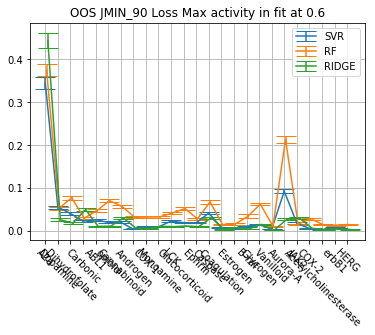

In [37]:
plotter(frac_fit=0.6, loss='jmin_90')

### OOS - max activity in fit 0.4

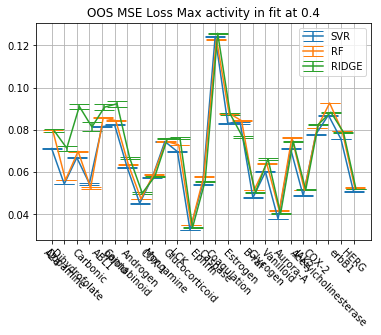

In [38]:
plotter(frac_fit=0.4)

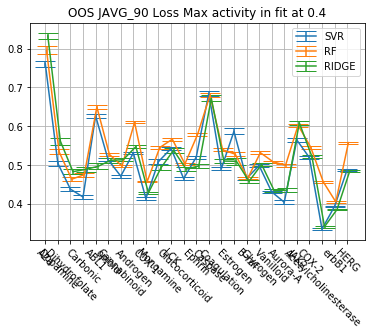

In [39]:
plotter(frac_fit=0.4, loss='javg_90')

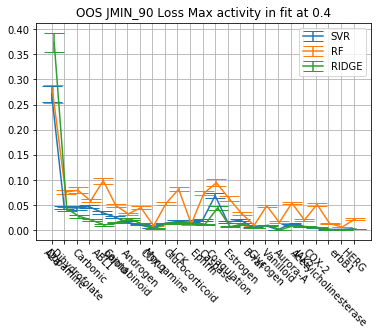

In [40]:
plotter(frac_fit=0.4, loss='jmin_90')

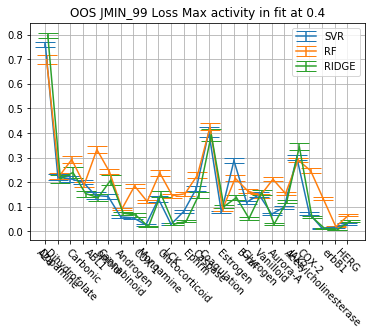

In [41]:
plotter(frac_fit=0.4, loss='jmin_99')

### LL estimates...

In [42]:
# Since the estimates have wide tails away from 0, we're going to (as a conservative estimate)
# of relative log likelihood, look at how many (2-lower-standard errors away from 0 the mean is)

def ll_estimate(frac_fit=1.0, losses=['javg_90', 'mse', ], kf=0):
    fnf = get_fn(frac_fit, kf=0)
    loss_hdr = joblib.load(fnf)
    
    print(('%9s |' + '%9s |' * len(losses)) % tuple(['',] + losses))
    print('-' * (11 * (len(losses) + 1) - 1))
    for (i, method) in enumerate(model_dict.keys()):
        
        lls = []
        
        for loss in losses:
            ll = 0
            for tgt in sorted_targets:
                lmean = loss_hdr[tgt][method][loss]['loss']
                llow = loss_hdr[tgt][method][loss]['loss_l']
                sigmas = (lmean - llow)/2
                if lmean == 0:
                    continue # same as subrtacting 0
                else:
                    sigmas_from_zero = lmean/sigmas
                    ll += sigmas_from_zero**2/2
                    pass
                pass
            lls.append(ll)
            pass
        
        print (('%9s |' + '%9.1f |' * len(losses)) % tuple([method,] + lls))
    
    return

In [43]:
ll_estimate()

          |  javg_90 |      mse |
--------------------------------
      svr | 248009.1 |1415047.9 |
       rf | 161195.4 |1103439.6 |
    ridge | 323856.5 |1802987.6 |


In [44]:
ll_estimate(frac_fit=0.9)

          |  javg_90 |      mse |
--------------------------------
      svr | 810281.8 |3740442.4 |
       rf | 751443.3 |3991160.2 |
    ridge | 797670.9 |4482141.3 |


In [45]:
ll_estimate(frac_fit=0.8)

          |  javg_90 |      mse |
--------------------------------
      svr | 986064.2 |4075464.6 |
       rf |1120931.2 |6376734.6 |
    ridge | 828804.4 |4541201.1 |


In [46]:
ll_estimate(frac_fit=0.6)

          |  javg_90 |      mse |
--------------------------------
      svr | 930036.0 |5170015.7 |
       rf |1487083.5 |10425434.6 |
    ridge | 824177.4 |4701629.2 |


In [47]:
ll_estimate(frac_fit=0.4)

          |  javg_90 |      mse |
--------------------------------
      svr | 808405.5 |7219033.5 |
       rf |1114720.4 |15779608.7 |
    ridge | 661078.3 |5081852.2 |


In [48]:
ll_estimate(losses=loss_dict.keys())

          |  javg_99 |  javg_95 |  javg_90 |  jmin_95 |  jmin_90 |      mse |  jmin_99 |
---------------------------------------------------------------------------------------
      svr |  34671.7 | 132991.8 | 248009.1 |   2447.2 |   1503.8 |1415047.9 |   3781.2 |
       rf |  18484.6 |  73798.9 | 161195.4 |   1207.4 |    634.1 |1103439.6 |   2828.1 |
    ridge |  35050.4 | 153244.7 | 323856.5 |   2874.7 |   2244.5 |1802987.6 |   4147.8 |


In [49]:
ll_estimate(losses=loss_dict.keys(), frac_fit=0.9)

          |  javg_99 |  javg_95 |  javg_90 |  jmin_95 |  jmin_90 |      mse |  jmin_99 |
---------------------------------------------------------------------------------------
      svr | 355502.2 | 637772.6 | 810281.8 |  12713.4 |   5166.3 |3740442.4 |  22027.2 |
       rf | 291769.8 | 584859.8 | 751443.3 |  15017.7 |   5309.2 |3991160.2 |  27740.2 |
    ridge | 301694.3 | 564994.5 | 797670.9 |   8364.3 |   4548.6 |4482141.3 |  14909.1 |


In [50]:
ll_estimate(losses=loss_dict.keys(), frac_fit=0.8)

          |  javg_99 |  javg_95 |  javg_90 |  jmin_95 |  jmin_90 |      mse |  jmin_99 |
---------------------------------------------------------------------------------------
      svr | 342082.8 | 682844.8 | 986064.2 |  11473.8 |   8936.6 |4075464.6 |  19749.2 |
       rf | 355054.4 | 708028.7 |1120931.2 |  15683.6 |   9145.3 |6376734.6 |  19655.1 |
    ridge | 291946.8 | 558065.0 | 828804.4 |   6544.7 |   4941.7 |4541201.1 |  13544.5 |


In [51]:
ll_estimate(losses=loss_dict.keys(), frac_fit=0.6)

          |  javg_99 |  javg_95 |  javg_90 |  jmin_95 |  jmin_90 |      mse |  jmin_99 |
---------------------------------------------------------------------------------------
      svr | 367025.2 | 618444.6 | 930036.0 |   8340.9 |   7151.2 |5170015.7 |  16005.6 |
       rf | 508163.0 | 941811.8 |1487083.5 |  15501.5 |  11934.0 |10425434.6 |  31890.6 |
    ridge | 258577.2 | 532977.3 | 824177.4 |   6870.2 |   5582.7 |4701629.2 |  13285.1 |


In [52]:
ll_estimate(losses=loss_dict.keys(), frac_fit=0.4)

          |  javg_99 |  javg_95 |  javg_90 |  jmin_95 |  jmin_90 |      mse |  jmin_99 |
---------------------------------------------------------------------------------------
      svr | 244659.6 | 464136.9 | 808405.5 |   7928.4 |   5701.9 |7219033.5 |  23320.4 |
       rf | 306262.9 | 645749.9 |1114720.4 |  15653.1 |  12066.2 |15779608.7 |  24227.1 |
    ridge | 191883.1 | 388568.3 | 661078.3 |   6474.7 |   5043.0 |5081852.2 |  17750.9 |
